# Simulation of star PSF curve

- author : Sylvie Dagoret-Campagne
- afflilation : LAL-CNRS
- creation date : December 13th 2019
- update :December 14th 2019



In [234]:
import os
import re
import numpy as np

In [235]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [236]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [237]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import Table

In [238]:
from math import ceil,floor
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle

In [239]:
from numpy.core._multiarray_umath import ndarray
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

In [240]:
from scipy import interpolate

In [241]:
from scipy import optimize

In [242]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,8)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

# Definitions

## Addition includes

In [243]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [244]:
from FeaturesExtractor.config import set_logger
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

## Function

# Configuration

In [245]:
IMAGE_SIZE=50

In [246]:
THETA=45.*np.pi/180.

In [247]:
SIGMA_X=10
SIGMA_Y=6

In [248]:
X0=IMAGE_SIZE/2
Y0=IMAGE_SIZE/2

In [249]:
a=0.5*((np.cos(THETA)/SIGMA_X)**2+(np.sin(THETA)/SIGMA_Y)**2)

In [250]:
b=-np.sin(2*THETA)/4.*(-1./SIGMA_X**2 + 1./SIGMA_Y**2)

In [251]:
c=0.5*((np.sin(THETA)/SIGMA_X)**2+(np.cos(THETA)/SIGMA_Y)**2)

In [252]:
A=1000.

In [253]:
sat_fraction=0.5

In [254]:
def PSF(x,y):
    M=A*np.exp(-(a*(x-X0)**2 + 2*b*(y-Y0)*(x-X0) + c*(y-Y0)**2))
    if sat_fraction==0:
        return M
    else:
        Smax=sat_fraction*A
        S=np.where(M<Smax,M,Smax)
        return S

# Start

In [255]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Generate the image

## Background

In [256]:
background=np.random.normal(0,10,(IMAGE_SIZE,IMAGE_SIZE))

In [257]:
background-=background.min()

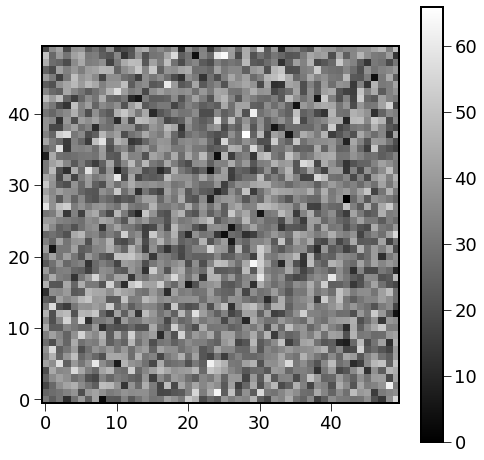

In [258]:
im=plt.imshow(background,origin="lower",cmap="gray")
plt.colorbar(im)

## Signal

In [259]:
X=np.arange(IMAGE_SIZE)
Y=np.arange(IMAGE_SIZE)

In [260]:
XX, YY = np.meshgrid(X, Y)

In [261]:
signal=PSF(XX,YY)

In [262]:
image=signal+background

Text(0.5, 0.98, 'signal + background with saturation f_sat = 0.5')

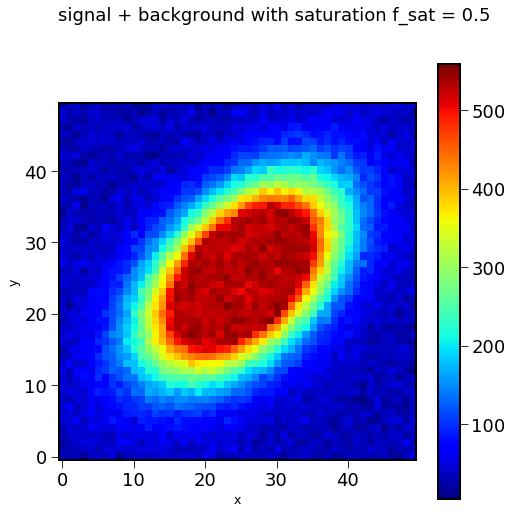

In [263]:
im=plt.imshow(image,origin="lower",cmap="jet")
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
title = "signal + background"
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title)

Text(0.5, 0.98, 'signal + background with saturation f_sat = 0.5')

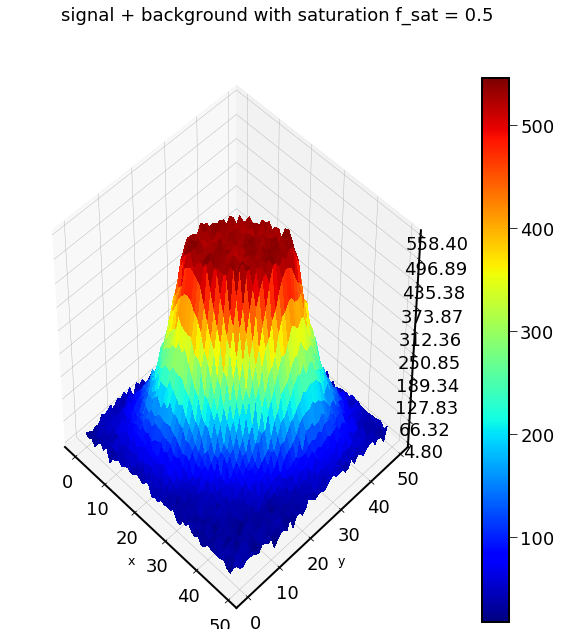

In [264]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
surf=ax.plot_surface(XX, YY, image, cmap="jet",antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(surf)




title = "signal + background"
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title)

# Compute the Hessian

In [265]:
lambda_plus, lambda_minus, theta = hessian_and_theta(image,margin_cut=1)

In [266]:
Nx=lambda_plus.shape[1]
Ny=lambda_plus.shape[0]

In [267]:
PadX=int((IMAGE_SIZE-Nx)/2)
PadY=int((IMAGE_SIZE-Ny)/2)

In [268]:
lambda_plus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))
lambda_minus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))

In [269]:
lambda_plus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_plus
lambda_minus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_minus

Text(0.5, 0.98, 'Lambda_plus with saturation f_sat = 0.5')

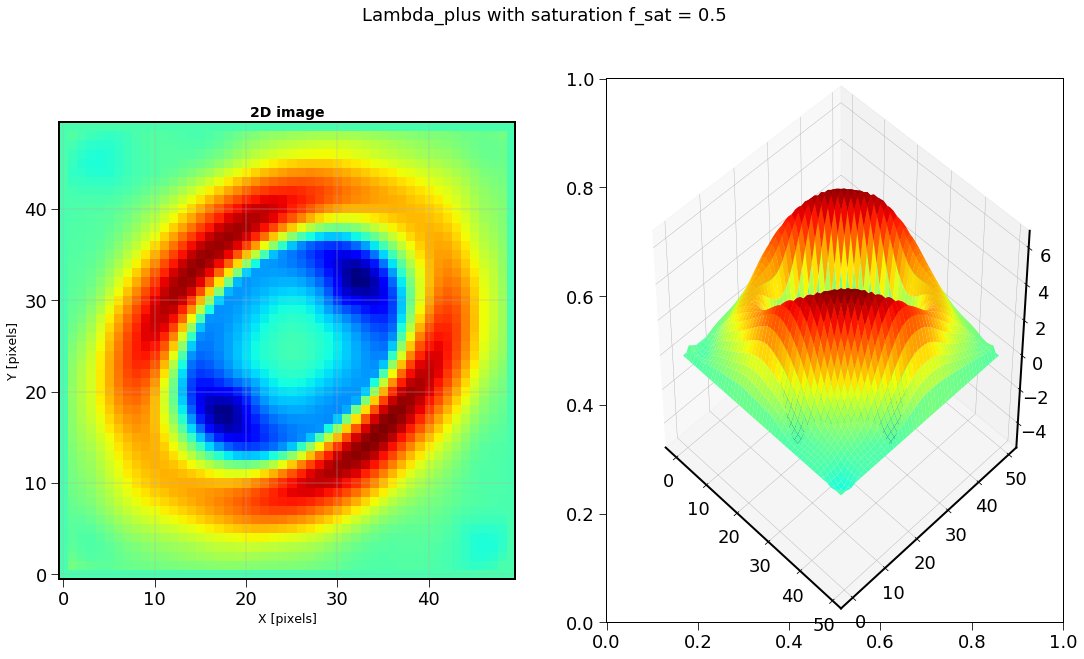

In [270]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_new, origin="lower", cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(45, -45)
ax2.plot_surface(XX, YY, lambda_plus_new, cmap=plt.cm.jet)
        

# fig.tight_layout()
title = "Lambda_plus"
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)


Text(0.5, 0.98, 'Lambda_minus with saturation f_sat = 0.5')

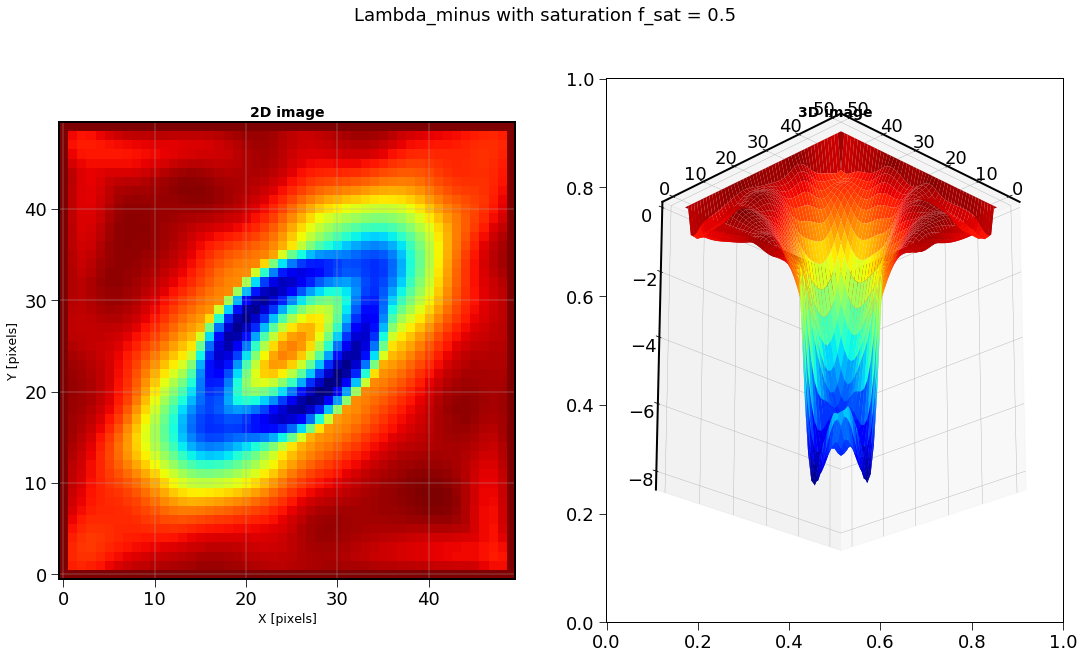

In [271]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_minus_new, origin="lower", cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('3D image', fontsize=14)
ax2.view_init(-20, 45)
ax2.plot_surface(XX, YY, lambda_minus_new, cmap=plt.cm.jet)
        
title = "Lambda_minus"
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)

# detect the edges

In [272]:
lambda_plus_edge=feature.canny(lambda_plus_new, sigma=5)
lambda_minus_edge=feature.canny(lambda_minus_new, sigma=5)

Text(0.5, 0.98, 'Canny edge detection with saturation f_sat = 0.5')

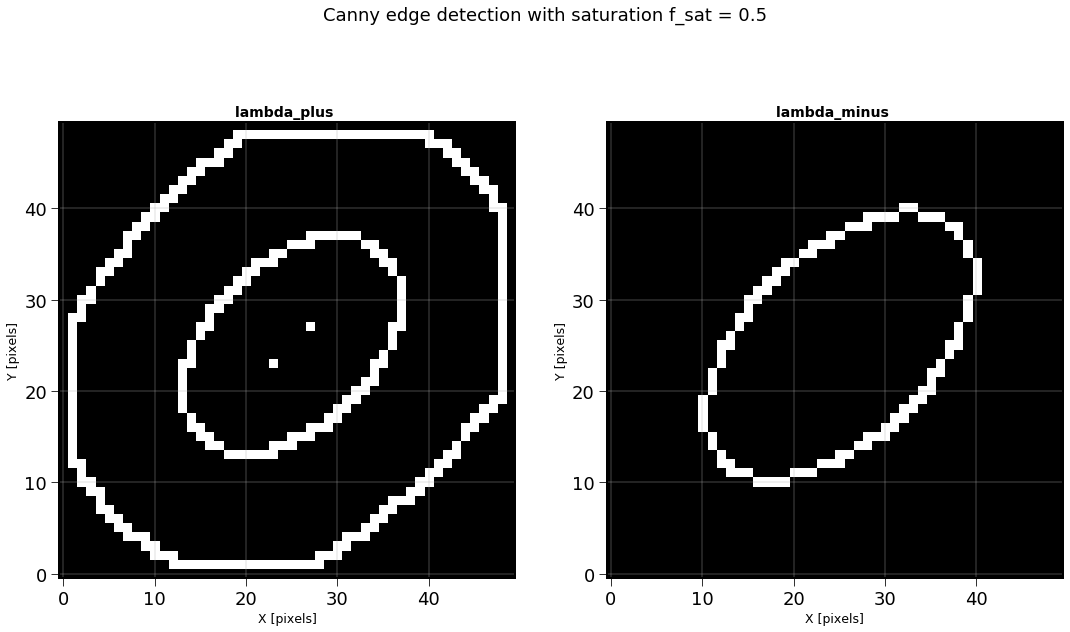

In [273]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_edge, origin="lower", cmap=plt.cm.gray)
ax1.set_title('lambda_plus ', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2.imshow(lambda_minus_edge, origin="lower", cmap=plt.cm.gray)
ax2.set_title('lambda_minus ', fontsize=14)
ax2.grid(True)
ax2.set_xlabel('X [pixels]')
ax2.set_ylabel('Y [pixels]')
        
title="Canny edge detection"
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"    
    
# fig.tight_layout()
plt.suptitle(title,fontsize=18)

## Interpolation

In [274]:
f_img = interpolate.interp2d(XX, YY, image, kind='linear')

In [275]:
f_lambda_plus = interpolate.interp2d(XX, YY, lambda_plus_new, kind='linear')

In [276]:
f_lambda_minus = interpolate.interp2d(XX, YY, lambda_minus_new, kind='linear')

In [277]:
def function_opt(x):
    return f_lambda_minus(x[0],x[1])[0]

In [278]:
title = "lambda_minus"

if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"  

In [279]:
bounds = [(0, image.shape[1]), (0, image.shape[1])]

In [280]:
results = dict()
results['shgo'] = optimize.shgo(function_opt, bounds)

In [281]:
results['shgo']

     fun: -8.318813754819312
    funl: array([-8.31881375])
 message: 'Optimization terminated successfully.'
    nfev: 145
     nit: 2
   nlfev: 140
   nlhev: 0
   nljev: 24
 success: True
       x: array([20.81308023, 29.14434045])
      xl: array([[20.81308023, 29.14434045]])

In [282]:
results['DA'] = optimize.dual_annealing(function_opt, bounds)

In [283]:
results['DA']

     fun: -8.428819710319598
 message: ['Maximum number of iteration reached']
    nfev: 4340
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([18.56679672, 26.38563141])

In [284]:
results['DE'] = optimize.differential_evolution(function_opt, bounds)

In [285]:
results['DE']

     fun: -8.383433355248473
     jac: array([ 0.40778723, -0.01161542])
 message: 'Optimization terminated successfully.'
    nfev: 525
     nit: 14
 success: True
       x: array([19.67184792, 27.94367989])

In [286]:
results['BH'] = optimize.basinhopping(function_opt, bounds)

In [287]:
results['BH']

                        fun: -1.0519004349992032
 lowest_optimization_result:       fun: -1.0519004349992032
 hess_inv: array([[ 9.40896520e-08, -3.19821799e-07,  0.00000000e+00,
         0.00000000e+00],
       [-3.19821799e-07,  1.24197185e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
      jac: array([0.04514885, 0.03439005, 0.        , 0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1242
      nit: 7
     njev: 205
   status: 2
  success: False
        x: array([ 3.15818233, 46.39297112, -4.69196493, 54.18215435])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 36
                       nfev: 32541
                        nit: 100
                       njev: 5356
                  

In [288]:
results['shgo_sobol'] = optimize.shgo(function_opt, bounds, n=200, iters=5,sampling_method='sobol')

In [289]:
results['shgo_sobol'] 

     fun: -8.953976041202901
    funl: array([-8.95397604, -8.80138783, -8.38429961, -8.3393645 , -8.33698823,
       -8.26508846, -7.91028637, -7.91028637, -7.68859404, -6.96511595,
       -1.4496669 , -1.21134141, -1.21134141, -1.09261909, -1.05190044,
       -1.05190043, -1.05190043, -1.05190043, -0.98441292, -0.98441292,
       -0.98441291, -0.98441291, -0.98441289, -0.98441288, -0.60369137,
       -0.60369137])
 message: 'Optimization terminated successfully.'
    nfev: 10289
     nit: 5
   nlfev: 9289
   nlhev: 0
   nljev: 1244
 success: True
       x: array([30.34569069, 21.44629098])
      xl: array([[30.34569069, 21.44629098],
       [27.32654443, 19.39158477],
       [19.67184792, 28.01825757],
       [21.67686396, 30.47716987],
       [32.63491002, 24.98881735],
       [17.44307075, 24.98881734],
       [23.44909625, 17.        ],
       [23.44909618, 16.99999999],
       [25.99999999, 32.92541733],
       [15.82730382, 16.03084161],
       [ 1.29146499,  2.63190345],
      

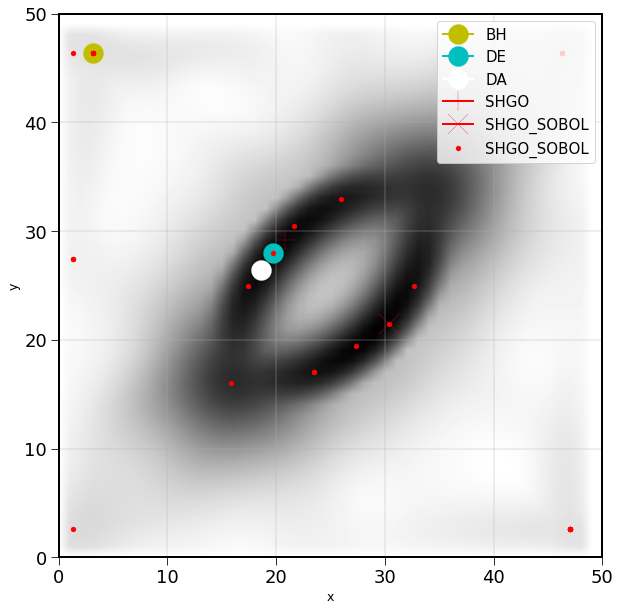

In [290]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(lambda_minus_new, interpolation='bilinear', origin='lower',cmap='gray')

ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None, ms=20,label=" "):
    ax.plot(res.x[0], res.x[1], marker=marker, color=color, ms=ms,label=label)

plot_point(results['BH'], color='y', label="BH")  # basinhopping           - yellow
plot_point(results['DE'], color='c', label="DE")  # differential_evolution - cyan
plot_point(results['DA'], color='w', label="DA")  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+',ms=20,label="SHGO")
plot_point(results['shgo_sobol'], color='r', marker='x',ms=20,label="SHGO_SOBOL")
for i in range(results['shgo_sobol'].xl.shape[0]):
    if i==0:     
        ax.plot(results['shgo_sobol'].xl[i, 0],results['shgo_sobol'].xl[i, 1],'ro', ms=5,label="SHGO_SOBOL")
    else:
        ax.plot(results['shgo_sobol'].xl[i, 0],results['shgo_sobol'].xl[i, 1],'ro', ms=5)

ax.set_xlim([0, image.shape[1]])
ax.set_ylim([0, image.shape[0]])
ax.legend(loc="upper right")  
ax.grid()
plt.show()